## Final Project Submission

Please fill out:
* Student name: 
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Housing development

In [1]:
# Your code here - remember to use markdown cells for comments as well!

Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

# 1. First Simple Model (FSM)

Importing data

In [3]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Each row represents data for houses that were sold in Kings County, including the prices they sold at and various aspects of the houses and their conditions at the time of sale.

Checking for dupes and nulls

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Checking correlations

In [200]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


Checking for multicollinearity

In [96]:
multi_df = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
multi_df['pairs'] = list(zip(multi_df.level_0, multi_df.level_1))
multi_df.set_index(['pairs'], inplace=True)
multi_df.drop(columns=['level_1', 'level_0'], inplace=True)

multi_df.columns = ['cc']
multi_df.drop_duplicates(inplace=True)
multi_df[(multi_df.cc>.75) & (multi_df.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


Our target variable is `price`.

Dropping variables and creating new df. Variables that were dropped were chosen for their low correlation with the target variable, indications of multicollinearity with other predictors, etc

In [45]:
housing_df = df.drop(['view', 'lat', 'long', 
                      'sqft_living15', 'sqft_lot15', 'zipcode', 
                      'sqft_above', 'sqft_basement', 'date', 
                      'yr_renovated'], axis = 1)

In [46]:
housing_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


Creating pairplot

Changing `id` column to strings. Each house has its own unique ID, so it doesn't make sense to include it with the numerical data that will be used to perform statistical analysis.

In [47]:
housing_df['id'] = housing_df['id'].astype(str)

In [48]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21597 non-null  object 
 1   price        21597 non-null  float64
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   sqft_living  21597 non-null  int64  
 5   sqft_lot     21597 non-null  int64  
 6   floors       21597 non-null  float64
 7   waterfront   19221 non-null  float64
 8   condition    21597 non-null  int64  
 9   grade        21597 non-null  int64  
 10  yr_built     21597 non-null  int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 1.8+ MB


Creating heat map and pairplot to find most useful features

In [49]:
corr_df = housing_df.corr()

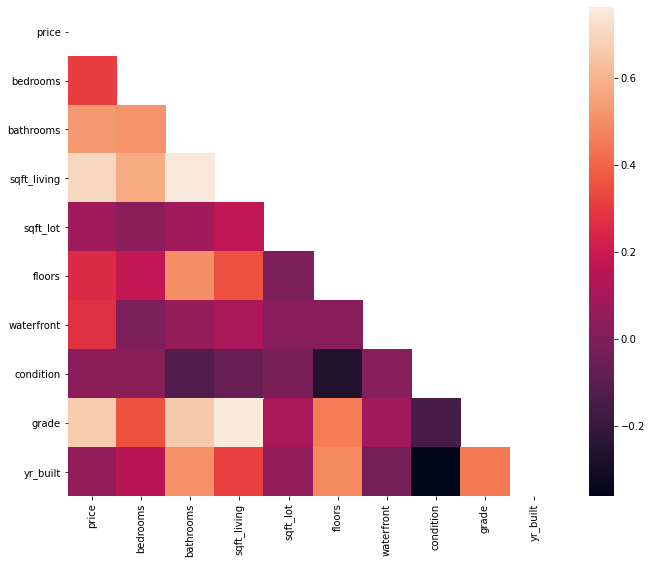

In [94]:
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_df, mask=mask, ax=ax1);

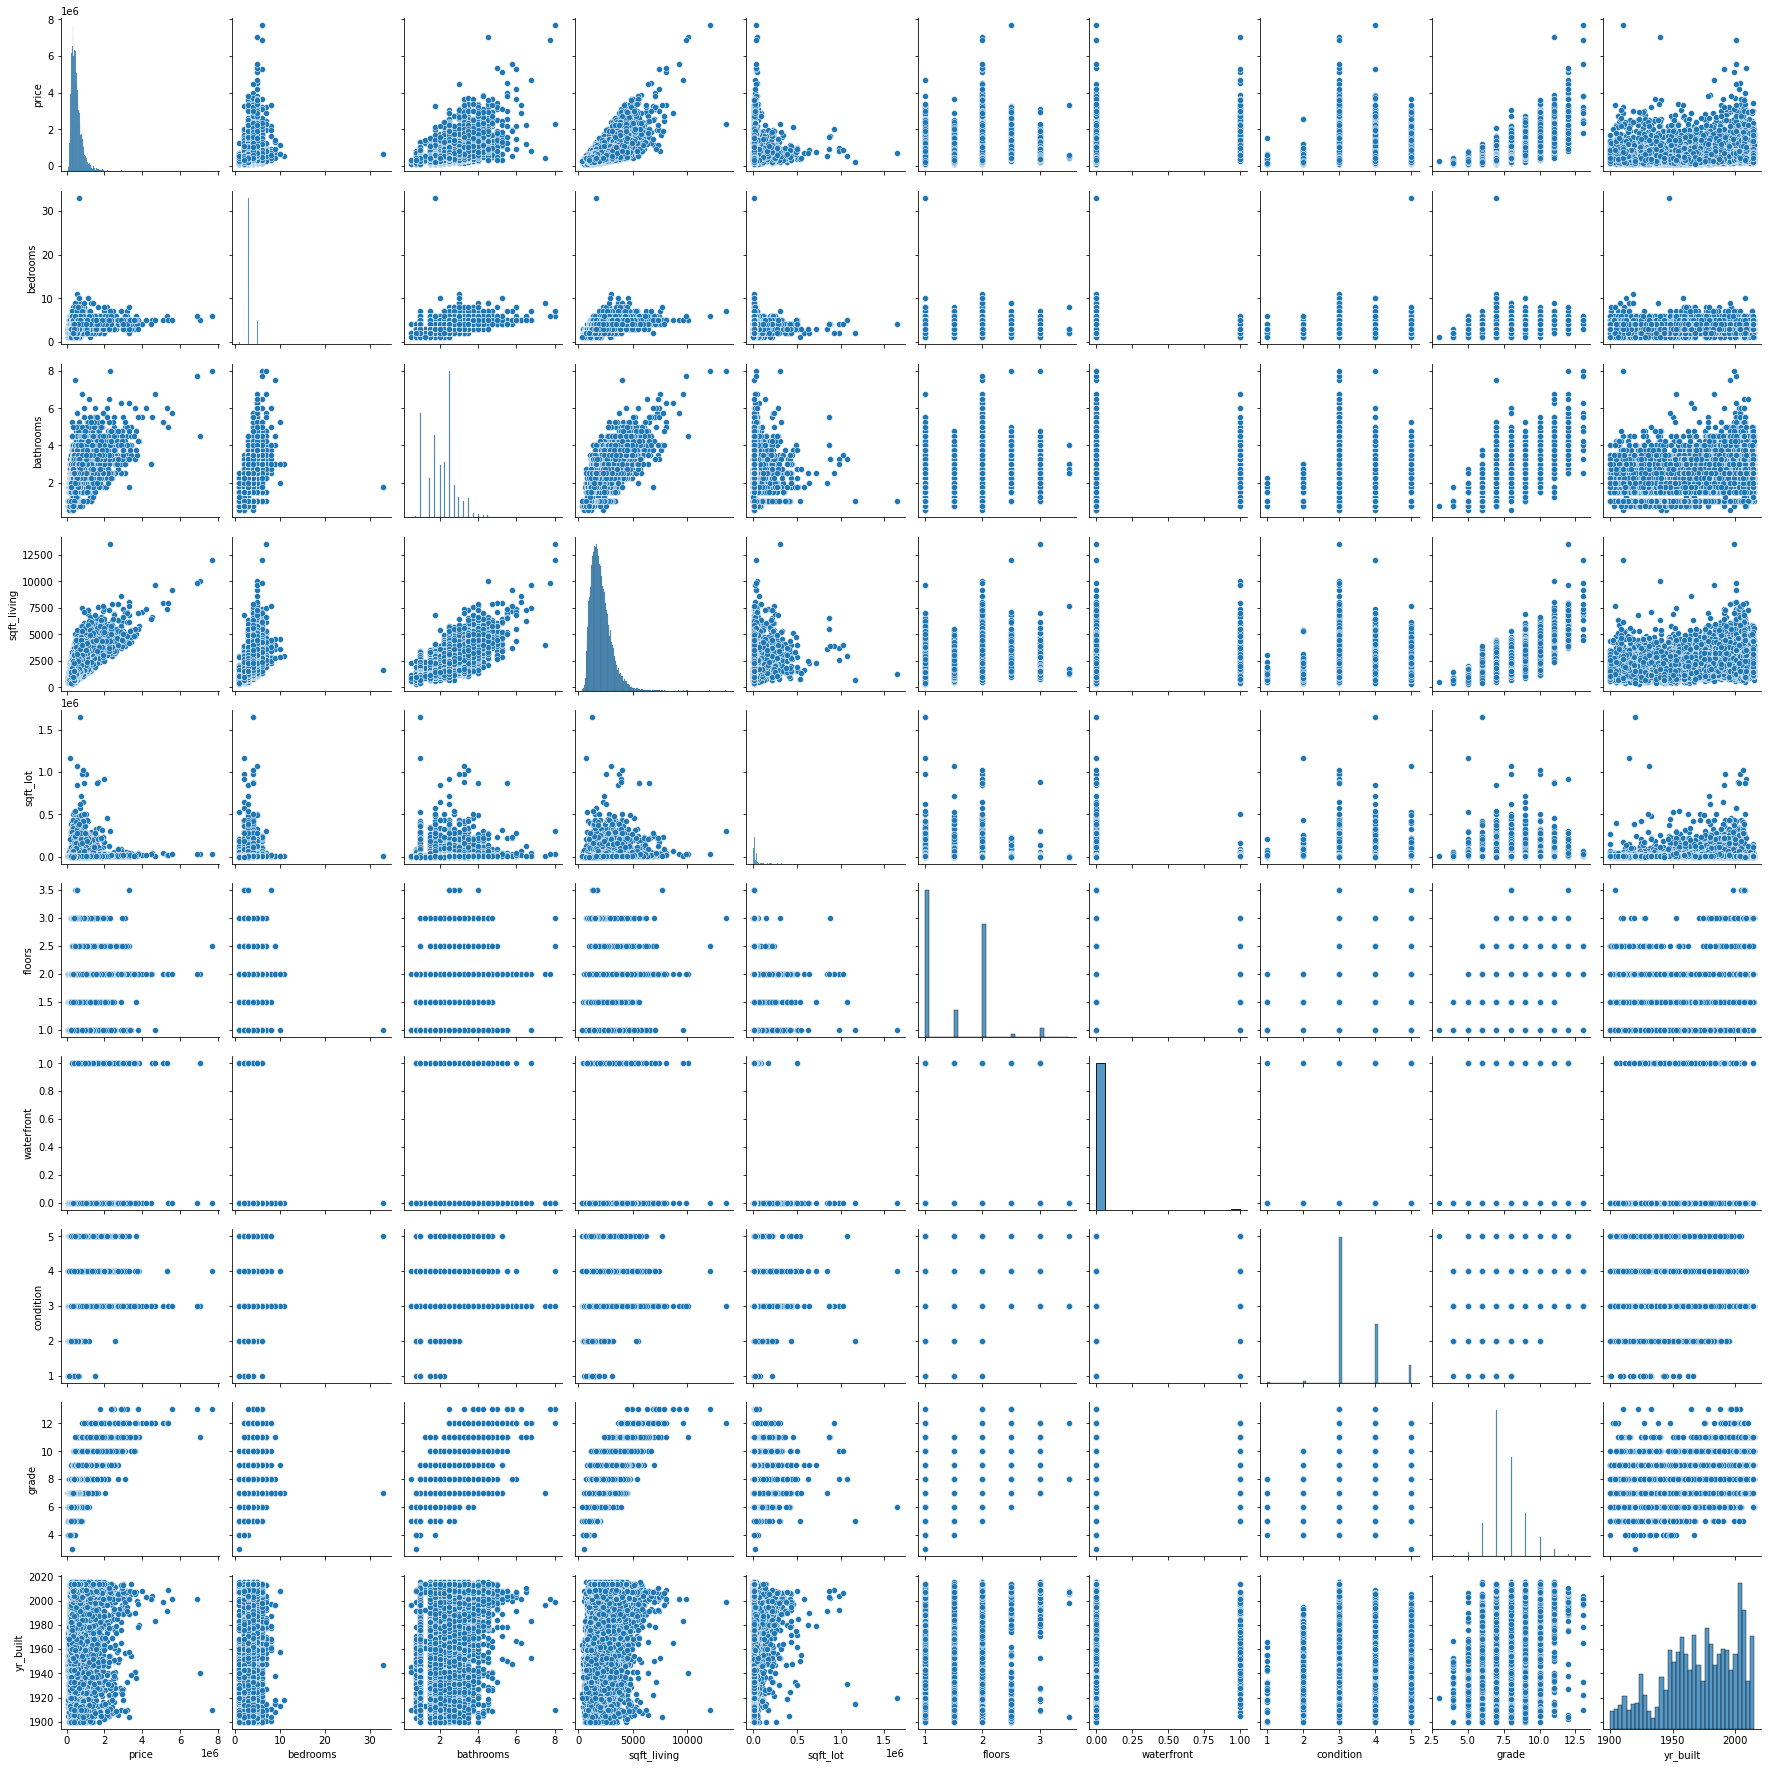

In [63]:
sns.pairplot(housing_df)

In [62]:
housing_df['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13], dtype=int64)

It seems that `sqft_living` has the most noticeable correlation with price, so first we'll create a model with `sqft_living`

In [15]:
fsm_df = housing_df[['price', 'sqft_living']]
fsm_df.head()

,price,sqft_living
0,221900.0,1180
1,538000.0,2570
2,180000.0,770
3,604000.0,1960
4,510000.0,1680


In [16]:
formula = 'price ~ sqft_living'

In [167]:
fsm_results = ols(formula=formula, data=fsm_df).fit()

In [168]:
fsm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:45:28   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
rsquared = fsm_results.rsquared
params = fsm_results.params

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: 0.49268789904035093
----------
Beta values of FSM:
Intercept     -43988.892194
sqft_living      280.863014
dtype: float64


### Checking assumptions of linear regression

Defining functions to check assumptions later

In [187]:
def linearity_test(model):
    rainbow_statistic, rainbow_p_value = linear_rainbow(model)
    print("Rainbow statistic:", rainbow_statistic)
    print("Rainbow p-value:", rainbow_p_value)
    
def normality_test(model):
    resids = model.resid
    fig = sm.graphics.qqplot(resids, dist=stats.norm, line='45', fit=True)
    fig.show()
    
def homoscadasticity(model):
    y_hat = model.predict()
    fig, ax = plt.subplots()
    ax.set(xlabel="Predicted Price",
           ylabel="Residuals (Actual - Predicted Price")
    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(fsm_resids, fsm_df[["sqft_living"]])
    print("Lagrange Multiplier p-value:", lm_p_value)
    print("F-statistic p-value:", f_p_value)
    return ax.scatter(y_hat, fsm_resids);

### 1. Linearity

In [185]:
linearity_test(fsm_results)

Rainbow statistic: 1.0880045442869077
Rainbow p-value: 5.894761434174282e-06


The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not. p-value is very low; at an alpha level of 0.05, we would reject the null, therefore this model violates the assumption of linearity

### 2. Normality

<ipython-input-161-7d6dbbf33cae>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


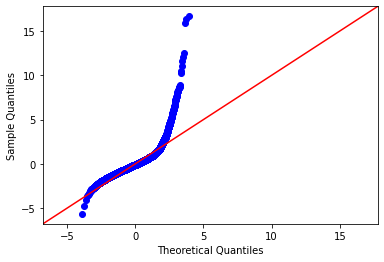

In [171]:
normality_test(fsm_results)

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. The JB score p-value is low, thus we would reject the null, meaning that the residuals are not normally distributed. The Q-Q plot also reflects this, showing that the model is skewed.

### 3. Homoscadasticity

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


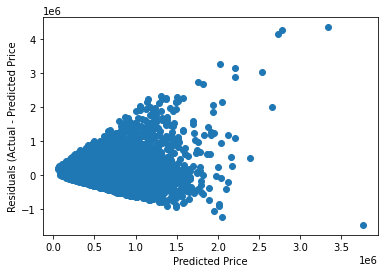

In [172]:
homoscadasticity(fsm_results)

The scatter plot has a cone shape, indicating that the scatter of the dependent variable widens as the value of the independent variable increases.

A low F-statistic means we would reject the null; therefore this model is heteroscedastic and violates the assumption of homoscedasticity.

### 4. Independence

The independence assumption means that the independent variables must not be too collinear.  Right now we have only one independent variable, so we don't need to check this yet.

## 2. Iterate: Build a better model - Add another numerical feature

In [127]:
housing_df['sqft_lot'].unique().sum()

208236234

In [125]:
model_2_df = housing_df[['price', 'sqft_living', 'sqft_lot']]
model_2_df.head()

,price,sqft_living,sqft_lot
0,221900.0,1180,5650
1,538000.0,2570,7242
2,180000.0,770,10000
3,604000.0,1960,5000
4,510000.0,1680,8080


In [128]:
model_2 = ols(formula="price ~ sqft_living + sqft_lot", data=model_2_df)
model_2_results = model_2.fit()

In [129]:
model_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.053e+04
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:58:30   Log-Likelihood:            -3.0004e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.433e+04   4405.869    -10.062      0.000    -5.3e+04   -3.57e+04
sqft_living   283.1438      1.967    143.927      0.000     279.288     287.000
sqft_lot       -0.2915      0.044     -6.684      0.000      -0.377      -0.206
==============================================================================
Omnibus:                    14737.142   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           534322.524
Skew:                           2.805   Prob(JB):                         0.00
Kurtosis:                      26.713   Cond. No.                     1.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Checking assumptions of linear regression for new model

### 1. Linearity

In [163]:
linearity_test(model_2_results)

Rainbow statistic: 1.0908272433312955
Rainbow p-value: 3.152586659132877e-06


### 2. Normality

<ipython-input-161-7d6dbbf33cae>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


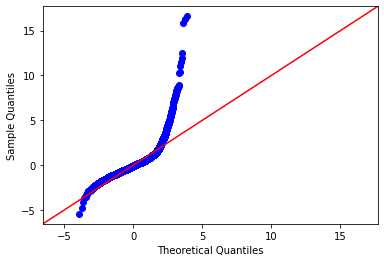

In [164]:
normality_test(model_2_results)

### 3. Homoscadasticity

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


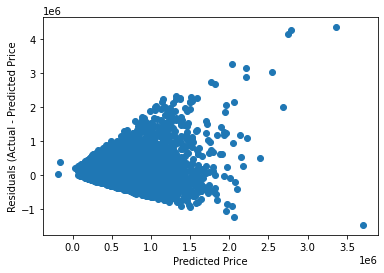

In [173]:
homoscadasticity(model_2_results)

### 4. Independence

In [194]:
rows = model_2_df[["sqft_living", "sqft_lot"]].values
    
vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ["sqft_living", "sqft_lot"]

vif_df

,VIF,feature
0,1.16793,sqft_living
1,1.16793,sqft_lot


## 3. Iterate: Build a better model - Add a categorical feature


We have no variables in this data set that consist of raw categorical data, but we can consider `condition` as a categorical feature, assuming it represents the quality of a house's condition upon sale on a scale from 1 to 5. Because these are already numerical values, we won't have to create dummy variables to represent the data.

In [43]:
df['condition'].unique()

array([3, 5, 4, 1, 2], dtype=int64)

In [148]:
model_3_df = housing_df[['price', 'sqft_living', 'sqft_lot', 'grade']]

In [149]:
model_3 = ols(formula="price ~ sqft_living + sqft_lot + grade", data=model_3_df)
model_3_results = model_3.fit()

In [150]:
model_3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     8295.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:25:51   Log-Likelihood:            -2.9911e+05
No. Observations:               21597   AIC:                         5.982e+05
Df Residuals:                   21593   BIC:                         5.983e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.011e+05   1.33e+04    -45.074      0.000   -6.27e+05   -5.75e+05
sqft_living   186.3532      2.896     64.344      0.000     180.676     192.030
sqft_lot       -0.2407      0.042     -5.760      0.000      -0.323      -0.159
grade        9.889e+04   2246.967     44.012      0.000    9.45e+04    1.03e+05
==============================================================================
Omnibus:                    16895.228   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           991094.879
Skew:                           3.287   Prob(JB):                         0.00
Kurtosis:                      35.529   Cond. No.                     3.49e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Checking assumptions

1. Linearity

In [198]:
linearity_test(model_3_results)

Rainbow statistic: 1.081469925693941
Rainbow p-value: 2.3668600329178402e-05


2. Normality

<ipython-input-187-a858f83265ef>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


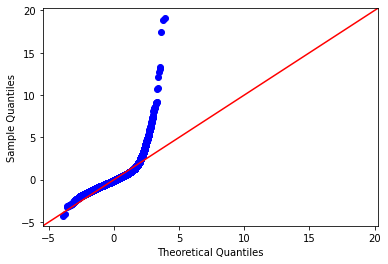

In [196]:
normality_test(model_3_results)

3. Homoscadsticity

Lagrange Multiplier p-value: nan
F-statistic p-value: 0.0


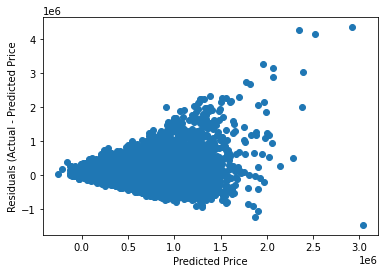

In [195]:
homoscadasticity(model_3_results)

4. Independence

In [152]:
rows = model_3_df[["sqft_living", "sqft_lot", "grade"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(3)]
vif_df["feature"] = ["sqft_living", "sqft_lot", "grade"]

vif_df

,VIF,feature
0,10.672713,sqft_living
1,1.168388,sqft_lot
2,10.455237,grade


## Conclusion